In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('precision', 5)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline

In [1]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [2]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [5]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [100]:
np.random.seed(2042)

Create train, validation and test set

In [101]:
valid_ratio, test_ratio = 0.2, 0.2
total_size = len(X_with_bias)
valid_size, test_size = int(total_size*valid_ratio), int(total_size*test_ratio)
train_size = total_size-valid_size-test_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:train_size+valid_size]]
y_valid = y[rnd_indices[train_size:train_size+valid_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

One hot y for matrix multiplication in Batch GD

In [102]:
def one_hot(vec):
    size = len(np.unique(vec))
    return np.identity(size)[vec]

In [103]:
y_train_oh = one_hot(y_train)
y_valid_oh = one_hot(y_valid)
y_test_oh = one_hot(y_test)

#### Batch Gradient Descent without regularization

In [300]:
def softmax(wx):
    e = np.exp(wx)
    return e / np.sum(e, axis=1).reshape(-1, 1)

In [301]:
def cross_entropy(probs, y_oh):
    epsilon = 1e-7
    return - np.sum(y_oh * np.log(probs+epsilon)) / len(y_oh)

In [302]:
eta = 0.1     # learning rate
n_iterations = 5000
m = train_size

np.random.seed(43)
theta = np.random.randn(X_with_bias.shape[1], 3)    # random initialization

best_accuracy = 0.0 #float("inf")
min_cost = np.infty
best_theta = None
best_epoch = None
accu_list = []
cost_list = []

for epoch in range(n_iterations):
    lin = X_train.dot(theta)
    sig = softmax(lin)
    gradients = X_train.T.dot(sig - y_train_oh) / m 
    theta = theta - eta * gradients
    
    train_lin = X_train.dot(theta)
    valid_lin = X_valid.dot(theta)
    
    train_accuracy = np.mean(np.argmax(train_lin, axis=1) == y_train)
    valid_accuracy = np.mean(np.argmax(valid_lin, axis=1) == y_valid)
    accu_list.append([train_accuracy, valid_accuracy])
    
    train_cost = cross_entropy(softmax(train_lin), y_train_oh)
    valid_cost = cross_entropy(softmax(valid_lin), y_valid_oh)
    cost_list.append([train_cost, valid_cost])
    
    if epoch == 0:
        print('epoch\t valid cost\t\t valid accuracy')
    if epoch % 500 == 0:
        print(epoch, '\t', valid_cost, '\t', valid_accuracy)
    
    if valid_cost < min_cost:
        min_cost = valid_cost
        best_accuracy = valid_accuracy 
        best_theta = theta
        best_epoch = epoch

epoch	 valid cost		 valid accuracy
0 	 2.1739877067282776 	 0.36666666666666664
500 	 0.39142622529619336 	 0.9666666666666667
1000 	 0.3032034963761374 	 0.9666666666666667
1500 	 0.2583495473155962 	 0.9666666666666667
2000 	 0.23023335912834775 	 0.9666666666666667
2500 	 0.21070680896127225 	 0.9666666666666667
3000 	 0.19624595431539246 	 0.9666666666666667
3500 	 0.18504137712742436 	 0.9666666666666667
4000 	 0.17606048723147 	 0.9666666666666667
4500 	 0.1686690166427392 	 0.9666666666666667


In [303]:
best_epoch

4999

In [304]:
best_accuracy

0.9666666666666667

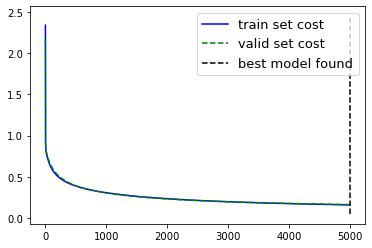

In [305]:
plt.plot(np.arange(n_iterations), np.array(cost_list)[:,0], 'b-',  label = 'train set cost')
plt.plot(np.arange(n_iterations), np.array(cost_list)[:,1], 'g--', label = 'valid set cost')
plt.plot([best_epoch, best_epoch], plt.ylim(), 'k--', label = 'best model found')
plt.legend(loc='upper right', fontsize=13)

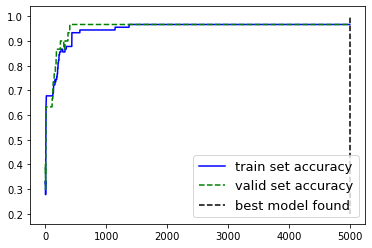

In [306]:
plt.plot(np.arange(n_iterations), np.array(accu_list)[:,0], 'b-',  label = 'train set accuracy')
plt.plot(np.arange(n_iterations), np.array(accu_list)[:,1], 'g--', label = 'valid set accuracy')
plt.plot([best_epoch, best_epoch], [0.2,1], 'k--', label = 'best model found')
plt.legend(loc='lower right', fontsize=13)

Predict on Test Set

In [307]:
test_accuracy = np.mean(np.argmax(X_test.dot(best_theta), axis=1) == y_test)

In [308]:
print(f"Under best model for valid set, Valid set accuracy is {best_accuracy:.2f} and Test set's is {test_accuracy:.2f}.")

Under best model for valid set, Valid set accuracy is 0.97 and Test set's is 0.97.


#### Batch Gradient Descent with l2 regularization and early stopping

In [309]:
eta = 0.1     # learning rate
n_iterations = 5000
m = train_size
alpha = 0.1

np.random.seed(43)
theta = np.random.randn(X_with_bias.shape[1], 3)    # random initialization

best_accuracy = 0.0
min_cost = float("inf")
best_theta = None

for epoch in range(n_iterations):
    lin = X_train.dot(theta)
    sig = softmax(lin)
    gradients = X_train.T.dot(sig - y_train_oh) / m + alpha * np.r_[np.zeros((1,theta.shape[1])), theta[1:]]
    theta = theta - eta * gradients
    
    train_lin = X_train.dot(theta)
    valid_lin = X_valid.dot(theta)
    
    train_accuracy = np.mean(np.argmax(train_lin, axis=1) == y_train)
    valid_accuracy = np.mean(np.argmax(valid_lin, axis=1) == y_valid)
    accu_list.append([train_accuracy, valid_accuracy])
    
    train_cost = cross_entropy(softmax(train_lin), y_train_oh) + 0.5 * alpha * np.sum(theta[1:]**2)
    valid_cost = cross_entropy(softmax(valid_lin), y_valid_oh) + 0.5 * alpha * np.sum(theta[1:]**2)
    cost_list.append([train_cost, valid_cost])
    
    if epoch == 0:
        print('epoch\t valid cost\t\t valid accuracy')
    if epoch % 200 == 0:
        print(epoch, '\t', valid_cost, '\t', valid_accuracy)
    
    if valid_cost < min_cost:
        min_cost = valid_cost 
        best_theta = theta
        best_accuracy = valid_accuracy
    else:
        print(epoch-1, '\t', min_cost, '\t', 'best model')
        break

epoch	 valid cost		 valid accuracy
0 	 2.4608976921043606 	 0.36666666666666664
200 	 0.6308207343618663 	 0.7666666666666667
400 	 0.5775251500802101 	 0.9
600 	 0.5578069247638868 	 0.9333333333333333
800 	 0.5475671220558262 	 0.9666666666666667
1000 	 0.5416289505777242 	 0.9666666666666667
1200 	 0.5380210152850942 	 0.9666666666666667
1400 	 0.5357866423502091 	 0.9666666666666667
1600 	 0.5343992749821476 	 1.0
1800 	 0.5335475327914019 	 1.0
2000 	 0.5330390472031126 	 1.0
2200 	 0.5327515990449028 	 1.0
2400 	 0.5326061079164086 	 1.0
2600 	 0.5325508148544884 	 1.0
2692 	 0.5325457982465033 	 best model


In [310]:
test_accuracy = np.mean(np.argmax(X_test.dot(best_theta), axis=1) == y_test)

In [311]:
print(f"Under best model for valid set, Valid set accuracy is {best_accuracy:.2f} and Test set's is {test_accuracy:.2f}.")

Under best model for valid set, Valid set accuracy is 1.00 and Test set's is 0.93.


#### plot predictions on the whole dataset

In [289]:
(X_train[:, 1:]).min(axis=0), (X_train[:, 1:]).max(axis=0)

(array([1. , 0.1]), array([6.9, 2.5]))

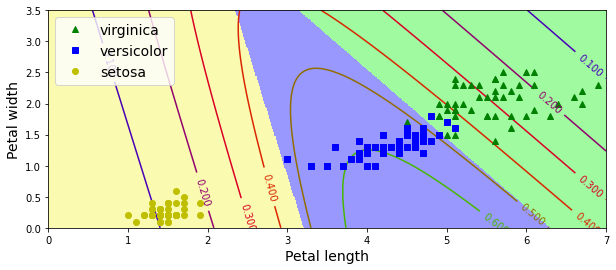

In [319]:
x0, x1 = np.meshgrid(
    np.linspace(0, 7, 500),
    np.linspace(0, 3.5, 500)
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones((len(X_new), 1)), X_new]

logits = X_new_with_bias.dot(best_theta)
Y_new_probs = softmax(logits)
y_new_predict = np.argmax(logits, axis=1)

# plot contour (decision boundary) only for class 1 "versicolor"
zz1 = Y_new_probs[:, 1].reshape(x0.shape)
zz = y_new_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label = 'virginica')
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label = 'versicolor')
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label = 'setosa')

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=True, fontsize=10)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()